In [2]:
import tensorflow.keras
from tensorflow.keras import layers

#size of encoded representations:
encoding_dim = 32

#input image
input_img=tensorflow.keras.Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = tensorflow.keras.Model(input_img, decoded)

In [4]:
#create a separate encoder model which maps an input to its encoded representation
encoder = tensorflow.keras.Model(input_img, encoded)

In [5]:
#also make a deocder model:
encoded_input = tensorflow.keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = tensorflow.keras.Model(encoded_input, decoder_layer(encoded_input))

In [6]:
#train autoencoder to reconstruct MNIST digits
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
#prepare input data
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [9]:
#normalize all values between 0 and 1
#also flatten 28X28 images into vectors of size 784
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [10]:
#train autoencoder
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 3s 10ms/step - loss: 0.2775 - val_loss: 0.1897
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1697 - val_loss: 0.1523
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1433 - val_loss: 0.1332
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1284 - val_loss: 0.1214
Epoch 5/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1185 - val_loss: 0.1131
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1115 - val_loss: 0.1073
Epoch 7/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1064 - val_loss: 0.1031
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1026 - val_loss: 0.0999
Epoch 9/50
235/235 [==============================] - 2s 8ms/step - loss: 0.0998 - val_loss: 0.0974
Epoch 10/50
235/235 [==============================] - 2s 7ms/step - loss: 0.0978 - val_loss: 0.095

In [11]:
#after 50 epochs, loss is pretty consistent around 0.09
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

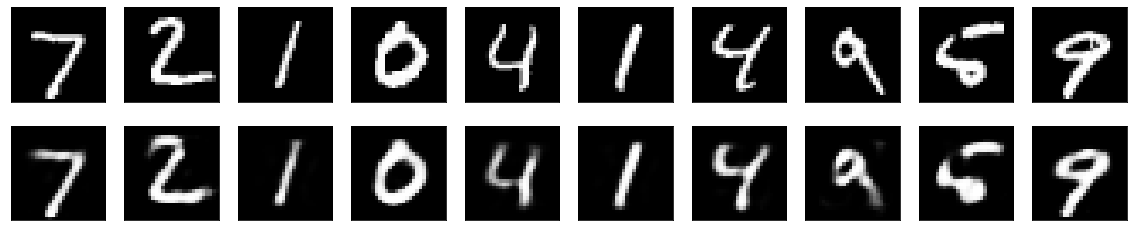

In [12]:
#test out the model - visualize reconstructed outputs
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
#so far the outputs look pretty sloppy
#next thing to do is to add a sparsity constraint on the encoded representations
#add an activity regulizer to the Dense layer
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = tensorflow.keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tensorflow.keras.Model(input_img, decoded)

In [15]:
#since there is more regularization, model is less likely to overfit
#so can be trained for longer - 70 epochs
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=70,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/70
235/235 [==============================] - 3s 11ms/step - loss: 0.2860 - val_loss: 0.2005
Epoch 2/70
235/235 [==============================] - 2s 10ms/step - loss: 0.1798 - val_loss: 0.1621
Epoch 3/70
235/235 [==============================] - 3s 12ms/step - loss: 0.1537 - val_loss: 0.1439
Epoch 4/70
235/235 [==============================] - 2s 10ms/step - loss: 0.1393 - val_loss: 0.1323
Epoch 5/70
235/235 [==============================] - 2s 7ms/step - loss: 0.1296 - val_loss: 0.1242
Epoch 6/70
235/235 [==============================] - 3s 12ms/step - loss: 0.1228 - val_loss: 0.1187
Epoch 7/70
235/235 [==============================] - 3s 11ms/step - loss: 0.1178 - val_loss: 0.1143
Epoch 8/70
235/235 [==============================] - 3s 11ms/step - loss: 0.1141 - val_loss: 0.1111
Epoch 9/70
235/235 [==============================] - 2s 10ms/step - loss: 0.1114 - val_loss: 0.1090
Epoch 10/70
235/235 [==============================] - 2s 7ms/step - loss: 0.1095 - val_loss

In [16]:
#deep autoencoder - use a stack of layers, has a bit lower loss
#than other autoencoders

#try convolutional autoencoder
#encoder will have a stack of Conv2D and MaxPooling2D layers
#decoder will have a stack of Conv2D and UpSampling2D layers

import tensorflow.keras
from tensorflow.keras import layers

input_img = tensorflow.keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tensorflow.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [17]:
#train using MNIST digits
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [18]:
#running tensorboard at localhost6060
#can moniter training from the tensorboard web interface
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 58s 120ms/step - loss: 0.2351 - val_loss: 0.1431
Epoch 2/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1331 - val_loss: 0.1237
Epoch 3/50
469/469 [==============================] - 57s 120ms/step - loss: 0.1207 - val_loss: 0.1158
Epoch 4/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1150 - val_loss: 0.1117
Epoch 5/50
469/469 [==============================] - 56s 120ms/step - loss: 0.1115 - val_loss: 0.1086
Epoch 6/50
469/469 [==============================] - 56s 120ms/step - loss: 0.1090 - val_loss: 0.1066
Epoch 7/50
469/469 [==============================] - 56s 120ms/step - loss: 0.1073 - val_loss: 0.1054
Epoch 8/50
469/469 [==============================] - 56s 120ms/step - loss: 0.1059 - val_loss: 0.1043
Epoch 9/50
469/469 [==============================] - 57s 121ms/step - loss: 0.1048 - val_loss: 0.1034
Epoch 10/50
469/469 [==============================] - 57s 122ms/step - l

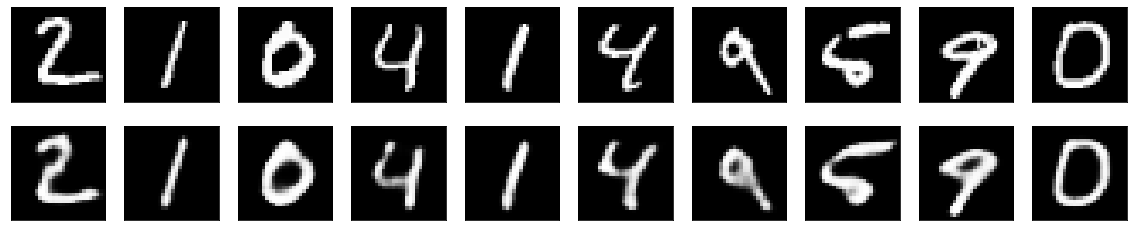

In [19]:
#see reconstructed digits
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
#applications to image denoising - train autoencoder
#to map noisy digits to clean ones, which cleans up the images
#and makes them the output
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

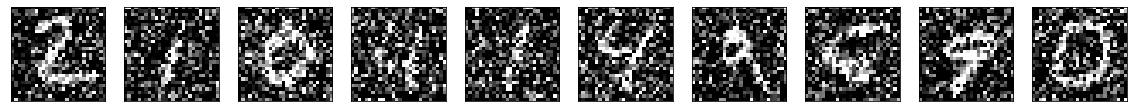

In [22]:
#show noisy digits: 
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
#use a slightly different model with more filters per layer
input_img = tensorflow.keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tensorflow.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
#train 
autoencoder.fit(x_train_noisy, x_train,
                epochs=40,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/40
469/469 [==============================] - 105s 222ms/step - loss: 0.1694 - val_loss: 0.1175
Epoch 2/40
469/469 [==============================] - 104s 222ms/step - loss: 0.1134 - val_loss: 0.1084
Epoch 3/40
469/469 [==============================] - 104s 221ms/step - loss: 0.1076 - val_loss: 0.1049
Epoch 4/40
469/469 [==============================] - 104s 221ms/step - loss: 0.1045 - val_loss: 0.1022
Epoch 5/40
469/469 [==============================] - 106s 225ms/step - loss: 0.1026 - val_loss: 0.1008
Epoch 6/40
469/469 [==============================] - 103s 220ms/step - loss: 0.1012 - val_loss: 0.0998
Epoch 7/40
469/469 [==============================] - 100s 213ms/step - loss: 0.1001 - val_loss: 0.0989
Epoch 8/40
469/469 [==============================] - 82s 175ms/step - loss: 0.0994 - val_loss: 0.0980
Epoch 9/40
469/469 [==============================] - 77s 165ms/step - loss: 0.0987 - val_loss: 0.0977
Epoch 10/40
469/469 [==============================] - 79s 168ms/s